In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
# %qtconsole

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

from dask.distributed import Client, LocalCluster
import dask
import logging

logging.basicConfig(level=logging.INFO)

client = Client(processes=False)

client

Client Scheduler: inproc://10.189.86.226/47781/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 4 Memory: 17.18 GB


In [4]:
from loren_frank_data_processing import get_position_dataframe
from src.parameters import ANIMALS

epoch_key = ('bon', 3, 2)

position_info = get_position_dataframe(epoch_key, ANIMALS, use_hmm=True,
                                        max_distance_from_well=5,
                                        route_euclidean_distance_scaling=1,
                                        min_distance_traveled=50,
                                        sensor_std_dev=10,
                                        spacing=30)

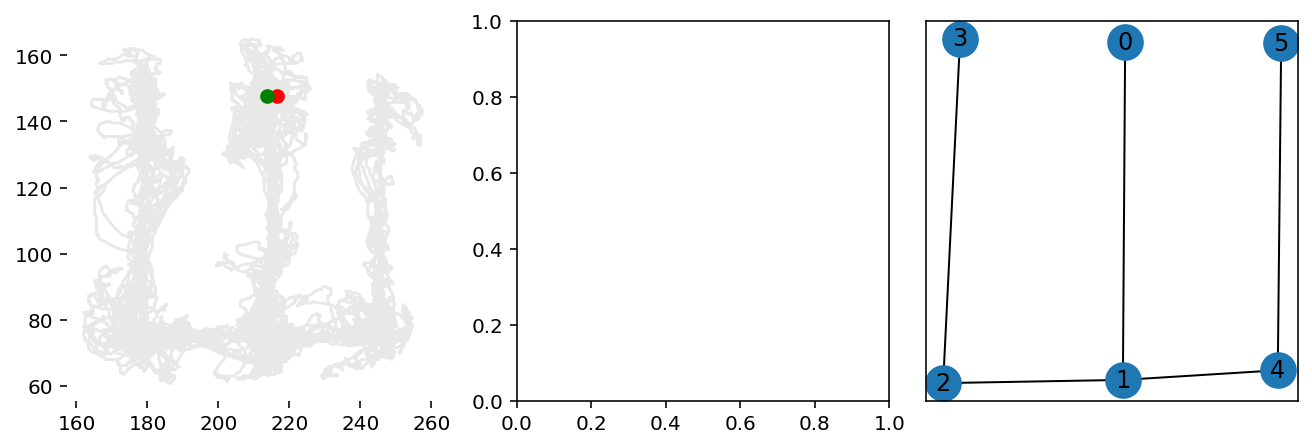

In [51]:
from loren_frank_data_processing.track_segment_classification import (
    get_track_segments_from_graph, project_points_to_segment, plot_track)
from loren_frank_data_processing.position import make_track_graph

import seaborn as sns

def get_projected_track_position(track_graph, track_segment_id, position):
    track_segment_id[np.isnan(track_segment_id)] = 0
    track_segment_id = track_segment_id.astype(int)

    track_segments = get_track_segments_from_graph(track_graph)
    projected_track_position = project_points_to_segment(
        track_segments, position)
    n_time = projected_track_position.shape[0]
    return projected_track_position[(
        np.arange(n_time), track_segment_id)]



track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)
position = position_info.loc[:, ['x_position', 'y_position']].values
track_segment_id = position_info.track_segment_id.values
projected_track_position = get_projected_track_position(track_graph, track_segment_id, position)

fig, axes = plt.subplots(1, 3, constrained_layout=True, figsize=(9, 3))

time_ind = 1000

axes[0].plot(position[:, 0], position[:, 1], color='lightgrey', alpha=0.5, zorder=0)
plot_track(track_graph, ax=axes[2])
axes[0].scatter(position[time_ind, 0], position[time_ind, 1],
                 color='red', zorder=10, s=40)
axes[0].scatter(projected_track_position[time_ind, 0], projected_track_position[time_ind, 1],
                 color='green', zorder=10, s=40)

sns.despine(left=True, bottom=True, ax=axes[0])

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '504x504', '-pix_fmt', 'rgba', '-r', '15', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-b', '1800k', '-metadata', 'artist=Me', '-y', 'actual_vs_linearized.mp4']


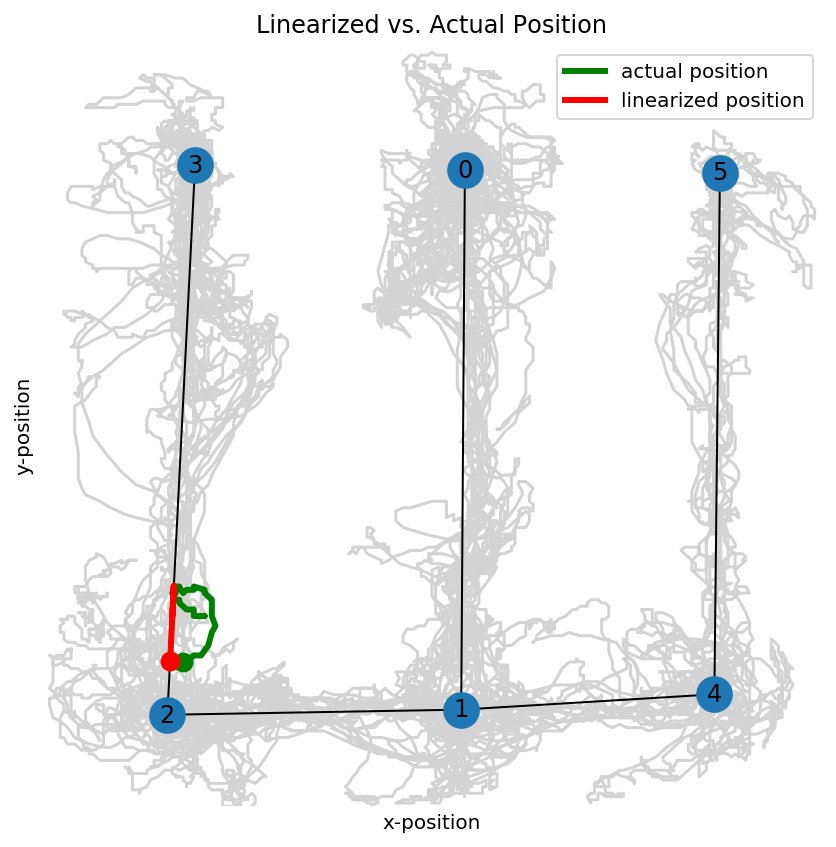

In [56]:
import matplotlib.animation as animation

def plot_linearization(position, projected_track_position, track_graph):
    # Set up formatting for the movie files
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

    fig, ax = plt.subplots(figsize=(7, 7))
    plt.plot(position[:, 0], position[:, 1], color='lightgrey', zorder=-10)
    plot_track(track_graph, ax)

    plt.xlim(position[:, 0].min() - 1, position[:, 0].max() + 1)
    plt.ylim(position[:, 1].min() + 1, position[:, 1].max() + 1)
    sns.despine(left=True, bottom=True, ax=ax)
    plt.title('Linearized vs. Actual Position')

    actual_line, = plt.plot([], [], 'g-', label='actual position', linewidth=3, zorder=101)
    actual_head = plt.scatter([], [], s=80, zorder=101, color='g')
    
    predicted_line, = plt.plot([], [], 'r-', label='linearized position', linewidth=3, zorder=102)
    predicted_head = plt.scatter([], [], s=80, zorder=102, color='r')

    plt.legend()


    def _update_line(time_ind):
        start_ind = max(0, time_ind - 33)
        time_slice = slice(start_ind, time_ind)

        actual_line.set_data(position[time_slice, 0], position[time_slice, 1])
        actual_head.set_offsets(position[time_ind])
            
        predicted_line.set_data(projected_track_position[time_slice, 0],
                                projected_track_position[time_slice, 1])
        predicted_head.set_offsets(projected_track_position[time_ind])

        return actual_line, predicted_line

    n_time = projected_track_position.shape[0]
    line_ani = animation.FuncAnimation(fig, _update_line, frames=n_time,
                                       interval=50, blit=True)
    line_ani.save('actual_vs_linearized.mp4', writer=writer)
    
    
plot_linearization(position, projected_track_position, track_graph)

In [57]:
from ipywidgets import Video

Video.from_file('actual_vs_linearized.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x01\x15\x12\xf3mdat\x0…

In [52]:
position_info.shape

(27901, 17)